<a href="https://colab.research.google.com/github/GGGRya/vicarious-therascope/blob/main/Vicarious_Trauma_Emotional_Symptoms_Text_Detection_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Model
We will build an LSTM model that takes as input word sequences that will take word ordering into account. We will use 50-dimensional [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained word embeddings to represent words. We will then feed those as an input into an LSTM that will predict the most appropiate emotion for the text. 

![alt text](https://drive.google.com/uc?id=1s-KYhU5JWF-jvAlZ2MIKKugxLLDdhpQP)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# HELPER FUNCTIONS

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def read_csv(filename):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [5]:
X_train, Y_train = read_csv('/content/drive/My Drive/Colab Notebooks/data/train.csv')
X_test, Y_test = read_csv('/content/drive/My Drive/Colab Notebooks/data/test.csv')

In [6]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [7]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/My Drive/Colab Notebooks/data/glove.6B.50d.txt')

In [8]:
def count_unknown_words(word_to_index, word_to_vec_map):
    unknown_words = set()
    for word in word_to_index:
        if word not in word_to_vec_map:
            unknown_words.add(word)
    num_unknown_words = len(unknown_words)
    print(f"{num_unknown_words} words out of {len(word_to_index)} are missing from the pre-trained word vectors.")
    return num_unknown_words
    print(num_unknown_words)

In [9]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    """
    
    m = X.shape[0]  # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):  # loop over training examples
        
        # Convert the ith sentence in lower case and split into a list of words
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1

        if j < max_len:
          X_indices[i, j:max_len] = 0
    
    return X_indices


In [10]:
X1 = np.array(["Sorry", "I feel sad", "this is so traumatic"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)
print(X1_indices.shape)

X1 = ['Sorry' 'I feel sad' 'this is so traumatic']
X1_indices = [[337914.      0.      0.      0.      0.]
 [185457. 146344. 315103.      0.      0.]
 [358160. 192973. 336114. 364293.      0.]]
(3, 5)


## Defining the Network using Pretrained Embedding Layer using GloVe Word Embeddings

In [11]:
class NN(nn.Module):
  def __init__(self, embedding, embedding_dim, hidden_dim, vocab_size, output_dim, batch_size):
      super(NN, self).__init__()

      self.batch_size = batch_size

      self.hidden_dim = hidden_dim

      self.word_embeddings = embedding

      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=2,
                          dropout = 0.5,
                          batch_first = True)

      # The linear layer that maps from hidden state space to output space
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, sentence):
      
      #sentence = sentence.type(torch.LongTensor)
      #print ('Shape of sentence is:', sentence.shape)

      sentence = sentence.to(device)

      embeds = self.word_embeddings(sentence)
      #print ('Embedding layer output shape', embeds.shape)

      # initializing the hidden state to 0
      #hidden=None
      
      h0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
      c0 = torch.zeros(2, sentence.size(0), hidden_dim).requires_grad_().to(device)
      
      lstm_out, h = self.lstm(embeds, (h0, c0))
      # get info from last timestep only
      lstm_out = lstm_out[:, -1, :]
      #print ('LSTM layer output shape', lstm_out.shape)
      #print ('LSTM layer output ', lstm_out)

      # Dropout
      lstm_out = F.dropout(lstm_out, 0.5)

      fc_out = self.fc(lstm_out)
      #print ('FC layer output shape', fc_out.shape)
      #print ('FC layer output ', fc_out)
      
      out = fc_out
      out = F.softmax(out, dim=1)
      #print ('Output layer output shape', out.shape)
      #print ('Output layer output ', out)
      return out
  

## Creating the Glove Embedding Layer

In [12]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len, non_trainable=True):
    num_embeddings = len(word_to_index) + 1                   
    embedding_dim = word_to_vec_map["cucumber"].shape[0] 

    weights_matrix = np.zeros((num_embeddings, embedding_dim))

    for word, index in word_to_index.items():
        if index >= num_embeddings:
            continue
        weights_matrix[index-1, :] = word_to_vec_map[word]

    embed = nn.Embedding.from_pretrained(torch.from_numpy(weights_matrix).type(torch.FloatTensor), freeze=non_trainable)

    return embed, num_embeddings, embedding_dim


## Training the model

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, trainloader, criterion, optimizer, epochs=10):
    
    model.to(device)
    running_loss = 0
    
    train_losses, test_losses, accuracies = [], [], []
    for e in range(epochs):

        running_loss = 0
        
        model.train()
        
        for sentences, labels in trainloader:

            sentences, labels = sentences.to(device), labels.to(device)

            # 1) erase previous gradients (if they exist)
            optimizer.zero_grad()

            # 2) make a prediction
            pred = model.forward(sentences)

            # 3) calculate how much we missed
            loss = criterion(pred, labels)

            # 4) figure out which weights caused us to miss
            loss.backward()

            # 5) change those weights
            optimizer.step()

            # 6) log our progress
            running_loss += loss.item()
        
        
        else:

          model.eval()

          test_loss = 0
          accuracy = 0
          
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():
              for sentences, labels in test_loader:
                  sentences, labels = sentences.to(device), labels.to(device)
                  log_ps = model(sentences)
                  test_loss += criterion(log_ps, labels)
                  
                  ps = torch.exp(log_ps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  
          train_losses.append(running_loss/len(train_loader))
          test_losses.append(test_loss/len(test_loader))
          accuracies.append(accuracy / len(test_loader) * 100)

          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
        
    # Plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_losses, c='b', label='Training loss')
    plt.plot(test_losses, c='r', label='Testing loss')
    plt.xticks(np.arange(0, epochs))
    plt.title('Losses')
    plt.legend(loc='upper right')
    plt.show()
    plt.figure(figsize=(20, 5))
    plt.plot(accuracies)
    plt.xticks(np.arange(0, epochs))
    plt.title('Accuracy')
    plt.show()
         



14
(132, 14)
Epoch: 1/50..  Training Loss: 1.633..  Test Loss: 1.623..  Test Accuracy: 0.125
Epoch: 2/50..  Training Loss: 1.612..  Test Loss: 1.617..  Test Accuracy: 0.125
Epoch: 3/50..  Training Loss: 1.608..  Test Loss: 1.612..  Test Accuracy: 0.109
Epoch: 4/50..  Training Loss: 1.606..  Test Loss: 1.608..  Test Accuracy: 0.094
Epoch: 5/50..  Training Loss: 1.596..  Test Loss: 1.602..  Test Accuracy: 0.344
Epoch: 6/50..  Training Loss: 1.584..  Test Loss: 1.598..  Test Accuracy: 0.234
Epoch: 7/50..  Training Loss: 1.559..  Test Loss: 1.599..  Test Accuracy: 0.297
Epoch: 8/50..  Training Loss: 1.539..  Test Loss: 1.624..  Test Accuracy: 0.234
Epoch: 9/50..  Training Loss: 1.520..  Test Loss: 1.569..  Test Accuracy: 0.328
Epoch: 10/50..  Training Loss: 1.513..  Test Loss: 1.557..  Test Accuracy: 0.281
Epoch: 11/50..  Training Loss: 1.503..  Test Loss: 1.596..  Test Accuracy: 0.312
Epoch: 12/50..  Training Loss: 1.489..  Test Loss: 1.564..  Test Accuracy: 0.281
Epoch: 13/50..  Training

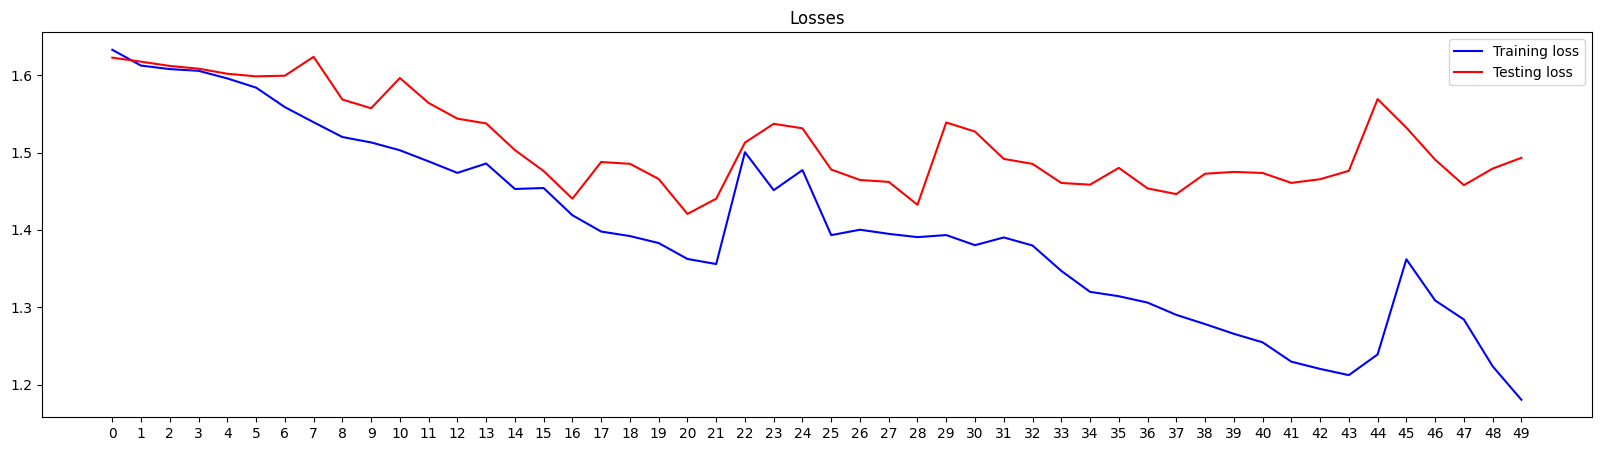

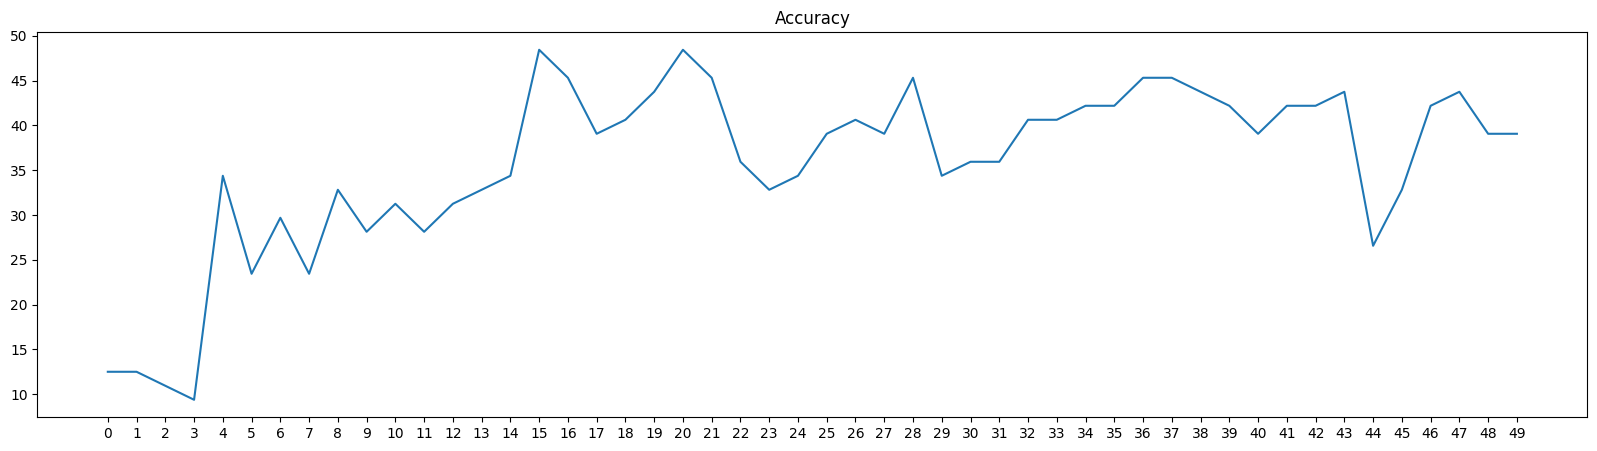

In [14]:
import torch.utils.data

max_len = len(max(X_train, key=len).split())
print(max_len)
for sentence in X_train:
    if len(sentence.split()) > max_len:
        print(sentence)

X_train_indices = sentences_to_indices(X_train, word_to_index, max_len)
print(X_train_indices.shape) 
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

X_test_indices = sentences_to_indices(X_test, word_to_index, max_len)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)

embedding, vocab_size, embedding_dim = pretrained_embedding_layer(word_to_vec_map, word_to_index, non_trainable=True, max_len=max_len)

hidden_dim= 128
output_size= 5
batch_size = 32

#print ('Embedding layer is ', embedding)
#print ('Embedding layer weights ', embedding.weight.shape)

model = NN(embedding, embedding_dim, hidden_dim, vocab_size, output_size, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
epochs = 50
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_indices).type(torch.LongTensor), torch.tensor(Y_train).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_indices).type(torch.LongTensor), torch.tensor(Y_test).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train(model, train_loader, criterion, optimizer, epochs)

## Testing the Model Accuracy

In [15]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for sentences, labels in test_loader:
        sentences, labels = sentences.to(device), labels.to(device)
        ps = model(sentences)
        test_loss += criterion(ps, labels).item()

        # Accuracy
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
model.train()
print("Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
running_loss = 0

Test Loss: 1.486..  Test Accuracy: 0.406


## Testing the model with any sentence

In [18]:
def predict(input_text, print_sentence=True):
  labels_dict = {
		0 : "Powerlesss/Survivor-guilty",
		1 : "Numb",
		2 : "Frightened/Anxious",
		3 : "Sad",
		4 : "Hopeful/Comfortable",
	}

  # Convert the input to the model
  x_test = np.array([input_text])
  X_test_indices = sentences_to_indices(x_test, word_to_index, max_len)
  sentences = torch.tensor(X_test_indices).type(torch.LongTensor)

  # Get the class label
  ps = model(sentences)
  top_p, top_class = ps.topk(1, dim=1)
  label = int(top_class[0][0])

  if print_sentence:
    print("\nInput Text: \t"+ input_text +'\nEmotion: \t'+  labels_dict[label])

  return label

In [19]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
print("------------------Vicarious Trauma Prediction------------------")
predict("It is too suffocating")
predict("Runaway from these as soon as possible")
predict("He is the poorest dog in the world")
print("\n---------------------------------------------------------------")

------------------Vicarious Trauma Prediction------------------

Input Text: 	It is too suffocating
Emotion: 	Hopeful/Comfortable

Input Text: 	Runaway from these as soon as possible
Emotion: 	Numb

Input Text: 	He is the poorest dog in the world
Emotion: 	Numb

---------------------------------------------------------------
